In [1]:
import numpy as np
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
from scipy.signal import welch

In [2]:
#read in data file and skip to data
file=open("/Users/Roslyn/Desktop/run-XXXII", "r")

In [3]:
with file as f:
    lines_after_6 = f.readlines()[7:]

In [4]:
#extract first two coloumns and convert to float
col1=[]
for x in lines_after_6:
    col1.append(float(x.split()[0]))
        
col2=[]
for x in lines_after_6:
    col2.append(float(x.split()[1]))
    
#combine real and imaginary parts to give list of complex data outputs
data=np.vectorize(complex)(col1, col2)

In [5]:
#enter constants
f_mode1 = 4.993017E6
f_mode2 = 5.505658500E+6 #- 2.8
kappa_1 = 0.000576417
kappa_2 = 0.000619449
Q1 = 4.4E7
Q2 = 4.84E7
dt=0.01
fs=100

w_mode1= 2*np.pi*f_mode1
w_mode2= 2*np.pi*f_mode2
tau1=Q1/w_mode1
tau2=Q2/w_mode2

h0=0.0005
trap=0.848

Zsquid= 1.2e6

In [6]:
data1=data[:10000000]

In [7]:
print(len(data))

24089000


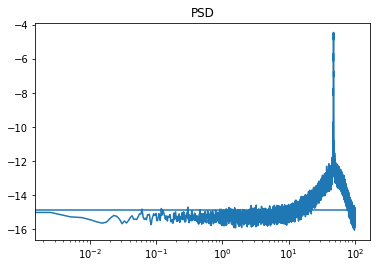

In [8]:
#PSD using Welch method 
f_1, S_1 = welch(
        (data1)-np.mean(data1), fs=fs, nperseg=(len(data1)/256),
         return_onesided=False, detrend=None, scaling='density', window='hanning')

#to plot log log have shifted frequency axis to positive 
plt.plot(f_1+abs(np.min(f_1)), 10*np.log10(S_1))
plt.title('PSD')
plt.xscale('log')


In [9]:
#SPECTRAL DISPLACEMENT DENSITY Su
#eq (8) GW Summary

#omega frequency axis, add mode freq 1 and convert from Hz to rad/s, and create squared axis 
w_1= [(x+f_mode1)*(2*np.pi) for x in f_1]
w_1sq= [x**2 for x in w_1]

#multiply 1/omega^2 list and Sv 
product1= [(1/a) * b for a, b in zip(w_1sq, S_1)]
 
#put into equation for Su(omega)
#10^-6 squared is a conversion from micro V to V
constants1 = (1/kappa_1**2)*(1/(Zsquid**2)*(10**(-6))**2)
Su1 = [x*(constants1) for x in product1]

Text(0.5, 1.0, 'Spectral Displacement Density')

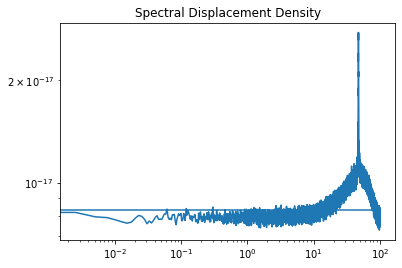

In [10]:
plt.plot(f_1+abs(np.min(f_1)), np.sqrt(Su1))
plt.xscale('log')
plt.yscale('log')
plt.title('Spectral Displacement Density')

In [11]:
#transfer function (equation 6 GW Summary)
def trans1(w):
    return np.absolute(((-w)**2*h0*trap/2)/((w*1j)**2+(w*1j)/tau1+w_mode1**2))

In [12]:
H_1=np.array(list(map(trans1,2*np.pi*(f_1+f_mode1))))

Text(0.5, 1.0, 'Transfer Function')

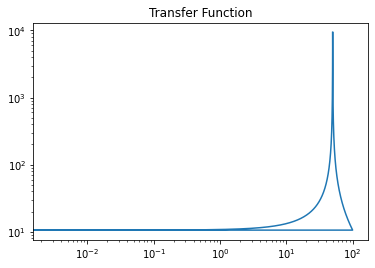

In [13]:
plt.plot(f_1+abs(np.min(f_1)), H_1)
plt.xscale('log')
plt.yscale('log')
plt.title('Transfer Function')

Text(0.5, 1.0, 'Strain Sensitivity ')

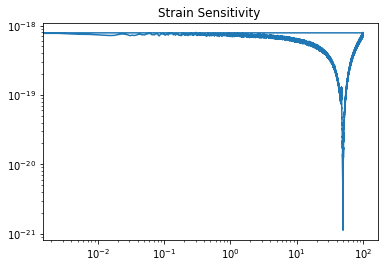

In [14]:
h_1=np.sqrt(Su1)/H_1

plt.plot(f_1+abs(np.min(f_1)), h_1)
plt.xscale('log')
plt.yscale('log')
plt.title('Strain Sensitivity ')

In [16]:
#convert Su back to complex time series 
Su1i=np.fft.ifft((np.sqrt(Su1)))
print(Su1i[:10])

[9.32643030e-18-2.21110487e-35j 7.97509365e-19-2.42114962e-20j
 1.65536730e-19-4.90393567e-20j 1.41131683e-19-7.28325971e-20j
 1.24751818e-19-8.93119340e-20j 1.11686640e-19-1.04711944e-19j
 8.98550082e-20-1.14201619e-19j 6.59522747e-20-1.25391342e-19j
 4.34246088e-20-1.31063251e-19j 2.45187356e-20-1.32539563e-19j]


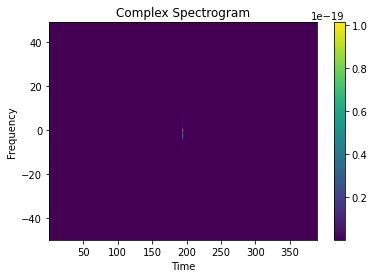

In [17]:
#complex data spectrogram
f, t, Sxx = signal.spectrogram(Su1i-np.mean(Su1i), 100, nperseg=100, return_onesided=False, mode='complex')
plt.pcolormesh(t, fftshift(f), fftshift(abs(Sxx)), shading='gouraud')
plt.colorbar()
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Complex Spectrogram')
plt.show()

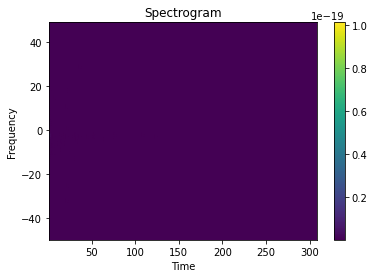

In [18]:
#extract section without power spike 
SxxA=np.array(Sxx)
SxxC= SxxA[0:100,0:350]

difft=np.delete(t[:351],0)

plt.pcolormesh(difft, fftshift(f), fftshift(abs(SxxC), axes=0), shading='gouraud')
plt.colorbar()
#plt.xlim(0,350)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Spectrogram')
plt.show()

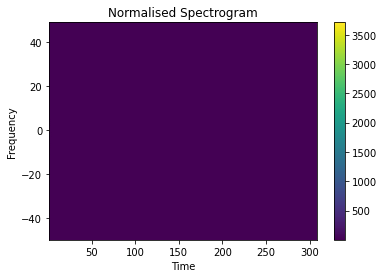

In [19]:
#FIND THRESHOLD NOISE AMPLITUDE AT FREQUENCY AWAY FROM RESONANT MODE 

#normalise data spectrogram 
absnormSxx=[]

for i in range(0,len(SxxC)):
    absnormSxx.append(abs((SxxC[i]/np.median(abs(SxxC[i])))))
    
plt.pcolormesh(difft, fftshift(f), fftshift(absnormSxx, axes=0), shading='gouraud')
plt.colorbar()
#plt.xlim(0,350)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Normalised Spectrogram')
plt.show()

In [20]:
#differencing for data spectrogram (D for data)

timecolsD=np.transpose(absnormSxx)

absdiffD=[]
slice1=[]

for j in range(0,len(absnormSxx)):
    slice1.clear()
    for i in range(0,(len(absnormSxx[0])-1)):
        slice1.append(abs(timecolsD[i+1][j]-timecolsD[i][j]))
    absdiffD.append(slice1[:])
    
#print(len(absdiffD))
#print(len(absdiffD[0]))

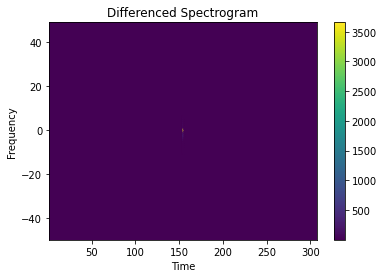

In [21]:
difftD=np.delete(t[:350],0)

plt.pcolormesh(difftD, fftshift(f), np.array(fftshift(absdiffD)), shading='gouraud')
plt.colorbar()
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Differenced Spectrogram')
plt.show()

In [22]:
#select area away from res mode and find max amplitude (around 25-40Hz)

#this corresponds to frequency index approx 26-41
#print(np.shape(absdiffD))
#print(f)
absdiffDA=np.array(absdiffD)

noiserows=absdiffDA[26:41,:].copy()
print(np.shape(noiserows))

threshold=np.amax(noiserows)
print(threshold)

(15, 349)
6.495082263798025


In [23]:
#create loop which essentially completes transient difference stest for 100 delta functions 
#at each of a range of h amplitudes to count if they are above threshold 

In [24]:
#(range and arange don't work well with non integer values)
h=np.linspace(1e-22,1e-21,10)
#print(len(h))
#print(h)

In [25]:
#create simulated transient for each h amplitude and resample to match dimension of spec to add
Su_sim=[]
slice2=[]

for i in range(0,len(h)):
    slice2.clear()
    for j in range(0,len(H_1)):
        slice2.append((h[i]*abs(H_1[j])))
    Su_sim.append(signal.resample(slice2[:],len(f)))
    #Su_sim.append(slice2[:])
        
print(np.shape(Su_sim))
#print(len(Su_sim))
#print(len(Su_sim[0]))
#print(Su_sim)

(10, 100)


In [26]:
#plt.plot(f_1+abs(np.min(f_1)), Su_sim[0])
#plt.plot(f_1+abs(np.min(f_1)), Su_sim[1])
#plt.plot(f_1+abs(np.min(f_1)), Su_sim[2])
#plt.plot(f_1+abs(np.min(f_1)), Su_sim[3])
#plt.xscale('log')
#plt.yscale('log')
#plt.title('Transient Sim Spectral Displacement Density')

#transient shape before resampling looks to be correct 

In [27]:
import random

In [28]:
count=0
allcounts=[]

for y in range(0,len(h)):
    for x in range(0,100):
        randomcol=random.randint(0,(len(SxxC[0])-1))
        #print(randomcol)
        SxxC[:,randomcol]= [a+b for a,b in zip(SxxC[:,randomcol],Su_sim[y])]
    
        absnormSxxsim=[]

        for k in range(0,len(SxxC)):
            absnormSxxsim.append(abs((SxxC[k]/np.median(abs(SxxC[k])))))
    
        #print(absnormSxxsim[0][0])
    
        timecols=np.transpose(absnormSxxsim)
        absdiff=[]
        slice3=[]

        for j in range(0,len(absnormSxxsim)):
            slice3.clear()
            for i in range(0,(len(absnormSxxsim[0])-1)):
                slice3.append(abs(timecols[i+1][j]-timecols[i][j]))
            absdiff.append(slice3[:])
    
        #print(absdiff[0][0])
    
        maxamp=np.amax(absdiff)
        print(maxamp)
    
        if maxamp > threshold:
            count+=1
    
        SxxC[:,randomcol]= [a-b for a,b in zip(SxxC[:,randomcol],Su_sim[y])]

    allcounts.append(count)
    count=0


#print(count)
print(allcounts)
    

    
   

11112.643555396262
11048.589397537962
11047.583728910415
11112.845001408294
11115.241090183554
11048.469026887744
11113.10123389145
11112.764886658286
11114.842360026792
11112.364804914878
11047.376169129766
11112.804942799303
11047.77220190716
11047.334707008193
11110.618139090673
11049.288385280897
11122.164981766364
11113.859389604764
11114.792493542984
11048.645356144008
11048.301132718096
11112.769965172354
11114.888140169556
11048.623288428573
11049.28023693272
11115.321946641798
11047.807197404094
11047.766553736645
11048.193050622536
11115.456009389092
11116.540468091478
11113.530644731178
11047.848735023084
11048.682494439456
11112.362534498065
11114.820802849052
11115.564533150487
11048.310597682112
11114.386598966523
11113.835785633953
11110.866549741868
11122.164981766364
11115.692020152472
11116.092013277257
11047.848735023084
11047.943464938062
11114.288603936317
11047.583728910415
11048.310597682112
11111.723633677122
11111.451322890862
11111.203347811323
11112.197607335

55242.725267638714
55573.00517465594
55570.839591404445
55243.31470469785
55243.33685064949
55243.22111538139
55243.07275565088
55571.12692196811
55243.780826260176
55242.96313273056
55570.724497580464
55242.97218987049
55569.82459940424
55242.093012224
55242.23980559354
55569.7738285477
55570.099805784776
55573.20084940923
55569.813217663555
55244.3908156002
55243.28789927118
55572.06001437252
55243.07444820069
55243.65890301843
55571.527078008294
55243.31600180261
55569.868083091584
55569.2285412767
55572.048135465986
55574.45396912883
55241.94792615054
55571.98355294178
55243.66243437401
55570.66691496121
55567.866505876125
55242.502246681725
55573.92650268949
55243.25926458885
55571.16691455928
55569.4466427513
55242.664126422
55243.69073058874
55573.00517465594
55242.97237753408
55243.83650878612
55242.23980559354
55570.569761990824
55242.897842321196
55574.3683320111
55242.43163291464
55242.885108238464
55570.64261538415
55244.293802296386
55573.20435421985
55242.06791416508
6668

111142.72630891434
111146.15334418602
111143.19798294293
110487.10381730345
111147.29575303408
110487.41604330047
110487.21368056112
110487.36994132423
111147.46335521153
111147.3208248497
111147.46335521153
110486.97367102471
111142.43773860407
110486.19860256113
111145.56783389919
111143.61940057806
111146.13505442691
111142.24303053603
110487.07155016996
110487.77947311623
110487.03539961402
111143.15506877606
110487.4577002725
110486.55615416708
111136.71365618477
110487.03539961402
110486.88578407414
111143.51195827585
110486.55376224178
110487.77947311623
111147.40645933214
110485.98201245455
110486.66481191084
110486.8139363201
111145.5406774923
111145.49335381608
111144.0843448025
111145.02208874187
111147.02912928848
110486.66481191084
111145.43689325984
111147.8549557982
110487.2513455279
110487.24767931303
110484.47165191892
111145.28152315924
110486.3023691636
110487.10868422368
111147.10346942658
110487.1653690082
111144.80713614196
111143.28559813801
110486.12305523104
11

Text(0, 0.5, 'Fraction of Events above threshold')

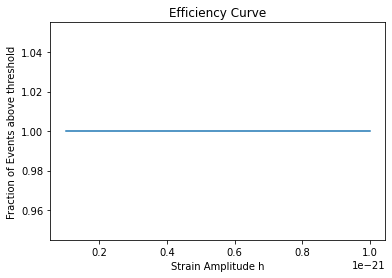

In [29]:
fraccounts=[x/100 for x in allcounts]

plt.plot(h,fraccounts)
plt.title('Efficiency Curve')
plt.xlabel('Strain Amplitude h')
plt.ylabel('Fraction of Events above threshold')
#plt.ylim(0,1)

In [30]:
#plt.pcolormesh(difft, fftshift(f), fftshift(abs(SxxC), axes=0), shading='gouraud')
#plt.colorbar()
#plt.xlim(0,350)
#plt.ylabel('Frequency')
#plt.xlabel('Time')
#plt.title('Sim Spectrogram')
#plt.show()

#looks like transient isnt being added

In [31]:
#plt.pcolormesh(difft, fftshift(f), fftshift((absnormSxxsim), axes=0), shading='gouraud')
#plt.colorbar()
#plt.xlim(0,350)
#plt.ylabel('Frequency')
#plt.xlabel('Time')
#plt.title('Norm Spectrogram')
#plt.show()